# European Football League Betting 

## Introduction

This is a review of the odds offered on matches across a selection of European football leagues from 2008 to 2016. I want to understand what margins bookmakers build into their odds, which bookmakers are most and least generous and what other similarities exist. The dataset includes approx. 25k matches, from 11 leagues, with odds from upto 10 bookmakers and is available at: https://www.kaggle.com/hugomathien/soccer.   

Given that the odds of a coin landing on a head or tail are 50/50, we can say that the sum of those two events is 100% or 1. In a similar way I want to see if the sum of the three possible football results (home win, draw or loss) also equate to 1. My expectation at the outset was that they do and that furthermore bookmakers insert a factor within these numbers to ensure they always make a profit. For example, if the probabilities sum to 1.05 the bookmaker's margin would be 5%. My understanding on bookmakers' margins and how odds are calculated is based on sources such as the following: https://www.investopedia.com/articles/dictionary/042215/understand-math-behind-betting-odds-gambling.asp. 

Spoiler alert!!! 

I was surprised to find that the sum of bookmakers match odds is actually < 1. At first I thought there must be an error in my analysis. Then I started to look at what this means in more detail. Does it imply that bookmakers are giving money away? Can we bet risk free or at least find easy strategies to win, like betting on the favourite or the long shot? Anyone familiar with the betting industry won't be surprised by the answers but hopefully the analysis will get us closer to understanding how odds really work.   

(Please note: I frequently refer to 'implied probabilities' that are < 1, impling that bookmakers are being potentially generous. However, I also talk about 'return rates' or the 'mean of winning odds' being < 1 which means the opposite).

## Assessing the data

The database contains multiple tables but for the purpose of this analysis I shall be using only 3: Match (containing match scores and bookmaker odds), League (containing league names) and Team (containing team names).

I started off by downloading the data and opening it in DB Browser for SQLite. Thereafter I interfaced with the database via this Jupyter notebook. (Warning: SQLite code differs to regular SQL in some areas. For example, it uses AVG rather AVE for calculating the mean.)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
% matplotlib inline

### (1) The League table

In [27]:
# Extract the League table

# Create connection to SQLite database
conn = sqlite3.connect('database.sqlite')

# Create a dataframe of all data from the League table using pandas to interface with SQLite 
df_assess_league = pd.read_sql("SELECT * From League", conn)

# Close the database connection
conn.close()
df_assess_league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


It's a small table and shows 11 leagues as expected. 

Note: it contains the 'id' field which we shall use later to join with the Match table.

### (2) The Team table 

In [26]:
# Extract the Team table and check the first and last few rows

conn = sqlite3.connect('database.sqlite')
df_assess_team = pd.read_sql("SELECT * From Team", conn)
conn.close()
df_assess_team.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [6]:
df_assess_team.tail(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
297,50204,7730,1862.0,FC Lausanne-Sports,LAU
298,51606,7896,NaN,Lugano,LUG


In [7]:
# Check type and data counts

df_assess_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [8]:
# Check unique values

df_assess_team.nunique()

id                  299
team_api_id         299
team_fifa_api_id    285
team_long_name      296
team_short_name     259
dtype: int64

As we can see the table includes a count of 299 unique team ids and a count of 299 team_long_names of which 296 are unique. I won't be working much with team names so this small amount of name duplication shouldn't be a problem. Team_short_name and fifa_api_id are out of scope. 

### (3) The Match table

In [52]:
# Extract the Match table and check first and last rows

conn = sqlite3.connect('database.sqlite')
df_assess_match = pd.read_sql("SELECT l.name, m.* From Match m LEFT JOIN League l ON m.league_id = l.id ", conn)
conn.close()
df_assess_match.head(2)

,name,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,Belgium Jupiler League,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,Belgium Jupiler League,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


In [10]:
df_assess_match.tail(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check the number of rows and columns in the table

df_assess_match.shape

(25979, 115)

In [14]:
# Check data types

df_assess_match.dtypes

id                    int64
country_id            int64
league_id             int64
season               object
stage                 int64
date                 object
match_api_id          int64
home_team_api_id      int64
away_team_api_id      int64
home_team_goal        int64
away_team_goal        int64
home_player_X1      float64
home_player_X2      float64
home_player_X3      float64
home_player_X4      float64
home_player_X5      float64
home_player_X6      float64
home_player_X7      float64
home_player_X8      float64
home_player_X9      float64
home_player_X10     float64
home_player_X11     float64
away_player_X1      float64
away_player_X2      float64
away_player_X3      float64
away_player_X4      float64
away_player_X5      float64
away_player_X6      float64
away_player_X7      float64
away_player_X8      float64
                     ...   
B365H               float64
B365D               float64
B365A               float64
BWH                 float64
BWD                 

In [15]:
# Some columns are missing above but we can pull the complete by using

for i, v in enumerate(df_assess_match.columns):
    print(i, v)

0 id
1 country_id
2 league_id
3 season
4 stage
5 date
6 match_api_id
7 home_team_api_id
8 away_team_api_id
9 home_team_goal
10 away_team_goal
11 home_player_X1
12 home_player_X2
13 home_player_X3
14 home_player_X4
15 home_player_X5
16 home_player_X6
17 home_player_X7
18 home_player_X8
19 home_player_X9
20 home_player_X10
21 home_player_X11
22 away_player_X1
23 away_player_X2
24 away_player_X3
25 away_player_X4
26 away_player_X5
27 away_player_X6
28 away_player_X7
29 away_player_X8
30 away_player_X9
31 away_player_X10
32 away_player_X11
33 home_player_Y1
34 home_player_Y2
35 home_player_Y3
36 home_player_Y4
37 home_player_Y5
38 home_player_Y6
39 home_player_Y7
40 home_player_Y8
41 home_player_Y9
42 home_player_Y10
43 home_player_Y11
44 away_player_Y1
45 away_player_Y2
46 away_player_Y3
47 away_player_Y4
48 away_player_Y5
49 away_player_Y6
50 away_player_Y7
51 away_player_Y8
52 away_player_Y9
53 away_player_Y10
54 away_player_Y11
55 home_player_1
56 home_player_2
57 home_player_3
58 home

In [54]:
# Count of match per league
df_assess_match['name'].value_counts()

England Premier League      3040
France Ligue 1              3040
Spain LIGA BBVA             3040
Italy Serie A               3017
Germany 1. Bundesliga       2448
Netherlands Eredivisie      2448
Portugal Liga ZON Sagres    2052
Poland Ekstraklasa          1920
Scotland Premier League     1824
Belgium Jupiler League      1728
Switzerland Super League    1422
Name: name, dtype: int64

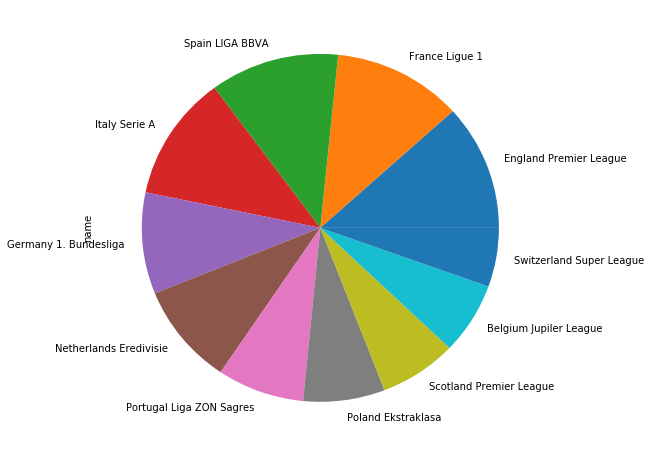

In [53]:
# Pie chart of count of matches per league
df_assess_match['name'].value_counts().plot(kind='pie', figsize=(8, 8));

In [5]:
# Let's look in more detail at the columns we'll be using

conn = sqlite3.connect('database.sqlite')
df_assess_match2 = pd.read_sql("SELECT B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA From Match", conn)
conn.close()
df_assess_match2.describe()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
count,22592.000000,22592.000000,22592.000000,22575.000000,22575.000000,22575.000000,22520.000000,22520.000000,22520.000000,22556.000000,...,17097.000000,22568.000000,22568.000000,22568.000000,14162.000000,14162.000000,14162.000000,14161.000000,14161.000000,14161.000000
mean,2.628818,3.839684,4.662222,2.559245,3.747597,4.396949,2.467613,3.608932,4.150575,2.536202,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
std,1.794463,1.118269,3.730104,1.637983,1.033468,3.292265,1.445642,0.803582,2.858912,1.640648,...,3.632164,1.928753,1.248221,4.318338,1.489299,0.867440,3.010189,1.507793,0.868272,3.189814
min,1.040000,1.400000,1.080000,1.030000,1.650000,1.100000,1.030000,1.500000,1.100000,1.040000,...,1.100000,1.030000,1.620000,1.080000,1.050000,1.450000,1.120000,1.040000,1.330000,1.120000
25%,1.670000,3.300000,2.500000,1.650000,3.200000,2.500000,1.650000,3.200000,2.500000,1.670000,...,2.500000,1.700000,3.300000,2.550000,1.670000,3.200000,2.500000,1.670000,3.250000,2.500000
50%,2.100000,3.500000,3.500000,2.100000,3.400000,3.400000,2.100000,3.300000,3.300000,2.100000,...,3.500000,2.150000,3.500000,3.500000,2.100000,3.300000,3.400000,2.100000,3.400000,3.400000
75%,2.800000,4.000000,5.250000,2.750000,3.800000,5.000000,2.600000,3.700000,4.600000,2.700000,...,5.250000,2.800000,4.000000,5.400000,2.650000,3.750000,5.000000,2.620000,3.750000,5.000000
max,26.000000,17.000000,51.000000,34.000000,19.500000,51.000000,20.000000,11.000000,25.000000,26.000000,...,41.000000,36.000000,26.000000,67.000000,21.000000,11.000000,34.000000,17.000000,13.000000,34.000000


Previously we saw that there are 25978 matches in the table, so we can see straight away in the table above that we don't have odds on every game. Also the count of odds for each per bookmaker differs (the lowest counts are to the far right). The NaN values in the following two tables show that these differences are due to missing leagues and, in some case, missing seasons. I intend to overlook these difference and to simply work with what we have.

In [28]:
# Bookmaker home win odds by league

conn = sqlite3.connect('database.sqlite')
df_assess_match3 = pd.read_sql("SELECT l.name, AVG(m.B365H) B365H, AVG(m.BWH) BWH, AVG(m.IWH) IWH, AVG(m.LBH) LBH, AVG(m.PSH) PSH, AVG(m.WHH) WHH, AVG(m.SJH) SJH, AVG(m.VCH) VCH, AVG(m.GBH) GBH, AVG(m.BSA) BSA FROM Match m LEFT JOIN League l ON m.league_id = l.id GROUP BY 1", conn)
conn.close()
df_assess_match3

,name,B365H,BWH,IWH,LBH,PSH,WHH,SJH,VCH,GBH,BSA
0,Belgium Jupiler League,2.412849,2.367367,2.291178,2.308276,2.493718,2.329701,2.401626,2.396223,2.330565,4.041182
1,England Premier League,2.701964,2.603906,2.513644,2.611787,2.720369,2.663760,2.667828,2.712200,2.606840,4.790621
2,France Ligue 1,2.409911,2.387721,2.309628,2.328643,2.578861,2.388524,2.360762,2.448107,2.306953,4.093595
3,Germany 1. Bundesliga,2.596530,2.541553,2.459705,2.530662,2.899665,2.571794,2.476984,2.635441,2.444260,4.115628
4,Italy Serie A,2.506616,2.472680,2.386254,2.430585,2.700534,2.489544,2.451414,2.557066,2.418675,4.355008
5,Netherlands Eredivisie,2.590569,2.504119,2.419101,2.448007,2.637873,2.485860,2.584475,2.595238,2.536457,4.866298
6,Poland Ekstraklasa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Portugal Liga ZON Sagres,2.938415,2.836936,2.667475,2.796773,3.313333,2.790240,2.783064,2.990725,2.680805,4.297097
8,Scotland Premier League,2.800493,2.641425,2.579450,2.764907,2.950639,2.774649,2.722375,2.859501,2.648026,4.192491
9,Spain LIGA BBVA,2.762152,2.701576,2.602997,2.663384,3.059525,2.732218,2.698544,2.859043,2.579070,4.674987


In [14]:
# Bookmaker home win odds by season

conn = sqlite3.connect('database.sqlite')
df_assess_match4 = pd.read_sql("SELECT Season, AVG(B365H), AVG(BWH), AVG(IWH), AVG(LBH), AVG(PSH), AVG(WHH), AVG(SJH), AVG(VCH), AVG(GBH), AVG(BSH) From Match GROUP BY 1", conn)
conn.close()
df_assess_match4

,season,AVG(B365H),AVG(BWH),AVG(IWH),AVG(LBH),AVG(PSH),AVG(WHH),AVG(SJH),AVG(VCH),AVG(GBH),AVG(BSH)
0,2008/2009,2.474600,2.397057,2.316700,2.335515,NaN,2.365481,2.453861,2.387098,2.420166,2.401509
1,2009/2010,2.602580,2.519231,2.443083,2.443900,NaN,2.501386,2.580265,2.552743,2.516033,2.514165
2,2010/2011,2.556769,2.470233,2.383155,2.456831,NaN,2.521865,2.538737,2.604327,2.475328,2.485200
3,2011/2012,2.635293,2.594952,2.450196,2.526122,NaN,2.586406,2.613782,2.720459,2.551276,2.570494
4,2012/2013,2.572136,2.535596,2.453559,2.493994,2.694003,2.550117,2.556343,2.652635,2.533492,2.520912
5,2013/2014,2.706918,2.639946,2.561957,2.651021,2.854260,2.699888,2.670000,2.791263,NaN,NaN
6,2014/2015,2.742397,2.656938,2.560915,2.709513,2.872152,2.717852,2.524595,2.854787,NaN,NaN
7,2015/2016,2.743893,2.664864,2.577109,2.677968,2.844983,2.694006,NaN,2.789008,NaN,NaN


## Exploring data - the odds for a home win

Before any football game starts the players will have a good warm-up. Before starting to answering the questions set out in the introduction I propose we do something similar by having a quick look to see if playing at home has any effect on teams' odds.

As it's the first in the list I will look at odds offered by the bookmaker Bet365 (B365). Firstly, across all teams and matches and then for a couple of well known teams, Manchester United and FC Barcelona.

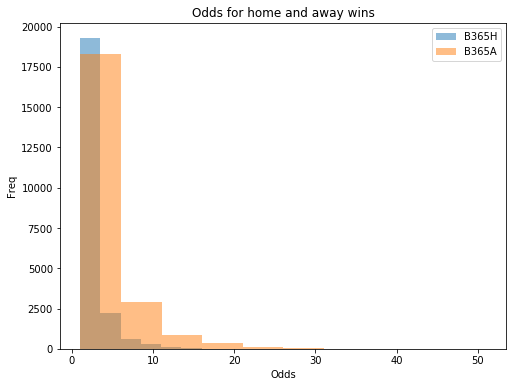

In [53]:
# Create dataframes for home and away odds

conn = sqlite3.connect('database.sqlite')
df_b365h = pd.read_sql("SELECT B365H FROM Match", conn)
df_b365a = pd.read_sql("SELECT B365A FROM Match", conn)
conn.close()

# Plot the dataframes on the same histogram

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_b365h['B365H'].dropna(), alpha=0.5, label='B365H')
ax.hist(df_b365a['B365A'].dropna(), alpha=0.5, label='B365A')
ax.set_title('Odds for home and away wins')
ax.set_xlabel('Odds')
ax.set_ylabel('Freq')
ax.legend(loc='upper right')
plt.show()

So it's not massive difference but there is clearly a difference between home and away odds, with away odds having a wider spread. This is the summary across all 299 teams that are in the database. Perhaps it will be more meaningful to look at it on club level. Let's see how it looks for Man Utd and Barça. 

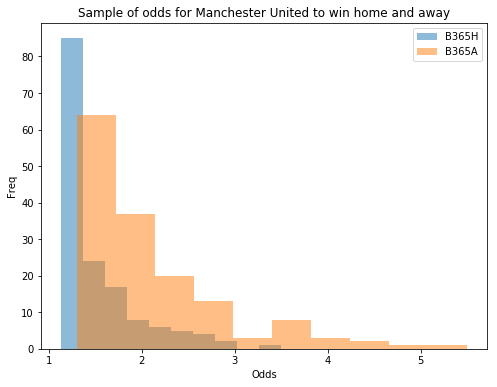

In [41]:
# Create dataframes for home and away odds, for Manchester United

conn = sqlite3.connect('database.sqlite')
df_b365h_manu = pd.read_sql("SELECT t1.team_long_name home_team, t2.team_long_name away_team, m.B365H FROM Match m LEFT JOIN Team t1 ON m.home_team_api_id = t1.team_api_id LEFT JOIN Team t2 ON m.away_team_api_id = t2.team_api_id WHERE t1.team_long_name = 'Manchester United'", conn)                            
df_b365a_manu = pd.read_sql("SELECT t1.team_long_name home_team, t2.team_long_name away_team, m.B365A FROM Match m LEFT JOIN Team t1 ON m.home_team_api_id = t1.team_api_id LEFT JOIN Team t2 ON m.away_team_api_id = t2.team_api_id WHERE t2.team_long_name = 'Manchester United'", conn)                            
conn.close()

# Plot the dataframes on the same histogram

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_b365h_manu['B365H'], alpha=0.5, label='B365H')
ax.hist(df_b365a_manu['B365A'], alpha=0.5, label='B365A')
ax.set_title('Sample of odds for Manchester United to win home and away')
ax.set_xlabel('Odds')
ax.set_ylabel('Freq')
ax.legend(loc='upper right')
plt.show()

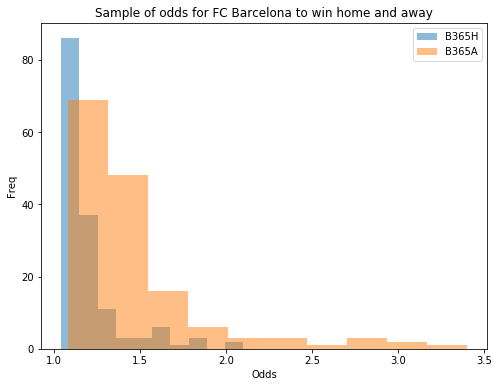

In [42]:
# Create dataframes for home and away odds, for FC Barcelona

conn = sqlite3.connect('database.sqlite')
df_b365h_manu = pd.read_sql("SELECT t1.team_long_name home_team, t2.team_long_name away_team, m.B365H FROM Match m LEFT JOIN Team t1 ON m.home_team_api_id = t1.team_api_id LEFT JOIN Team t2 ON m.away_team_api_id = t2.team_api_id WHERE t1.team_long_name = 'FC Barcelona'", conn)                            
df_b365a_manu = pd.read_sql("SELECT t1.team_long_name home_team, t2.team_long_name away_team, m.B365A FROM Match m LEFT JOIN Team t1 ON m.home_team_api_id = t1.team_api_id LEFT JOIN Team t2 ON m.away_team_api_id = t2.team_api_id WHERE t2.team_long_name = 'FC Barcelona'", conn)                            
conn.close()

# Plot the dataframes on the same histogram

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_b365h_manu['B365H'], alpha=0.5, label='B365H')
ax.hist(df_b365a_manu['B365A'], alpha=0.5, label='B365A')
ax.set_title('Sample of odds for FC Barcelona to win home and away')
ax.set_xlabel('Odds')
ax.set_ylabel('Freq')
ax.legend(loc='upper right')
plt.show()

So again according to the B365 odds, even the biggest teams, with the best players are less likely to win away from home. Whether a team plays at home or away isn't the only factor that will determine odds but we can see that it clearly is a factor and, in case you didn't know it already, it's worth bearing in mind as we go through the rest of the analysis.

## Exploring data - the implied probabilities per match

Bookmakers's odds are as per the below example. The column headings in the dataset are a composite of the bookmaker's name, in this case B365 (or Bet 365) and a letter indicating the event, a home win (H), a draw (D) or an away win (A). The odds themselves are in decimal format and are essentially a multiplier. In otherwords, if you bet 1€ at odds of 1.73, if successful, you'll receive back 1.73€, which includes your 1€ stake.

In [4]:
# Select the first odds from the list for bookmaker Bet 365

conn = sqlite3.connect('database.sqlite')
df_example_odds = pd.read_sql("SELECT B365H, B365D, B365A FROM Match WHERE id=1", conn)
conn.close()
df_example_odds

,B365H,B365D,B365A
0,1.73,3.4,5


We can already say that if the odds were < 1 then nobody would ever bet, as even in the event of a win you would lose money. Similarly if the odds of the most likely event would be > 3, then there would be no bookmakers, as we would be able to bet equally on all events and end with a profit.

But how do the odds of a match compare to those of a coin toss? To aid in this comparison we first need to convert our odds into an implied probability. We do this by dividing them into 1. For example, odds of 1.73 imply a probability of 1 / 1.73 = 0.578. I intend to use this approach across all odds, to sum the implied probabilities for home wins, draws or losses across all games and to compare them to 1. 

In [5]:
# Let's start high level, by calculating the implied odds per match, per bookmaker

# First let's extract from SQL the average of odds per bookmaker split by result

conn = sqlite3.connect('database.sqlite')
df_gam_SQLSQL = pd.read_sql("SELECT AVG(m.B365H) B365H, AVG(m.B365D) B365D, AVG(m.B365A) B365A, AVG(m.BWH) BWH, AVG(m.BWD) BWD, AVG(m.BWA) BWA, AVG(m.IWH) IWH, AVG(m.IWD) IWD, AVG(m.IWA) IWA, AVG(m.LBH) LBH, AVG(m.LBD) LBD, AVG(m.LBA) LBA, AVG(m.PSH) PSH, AVG(m.PSD) PSD, AVG(m.PSA) PSA, AVG(m.WHH) WHH, AVG(m.WHD) WHD, AVG(m.WHA) WHA, AVG(m.SJH) SJH, AVG(m.SJD) SJD, AVG(m.SJA) SJA, AVG(m.VCH) VCH, AVG(m.VCD) VCD, AVG(m.VCA) VCA, AVG(m.GBH) GBH, AVG(m.GBD) GBD, AVG(m.GBA) GBA, AVG(m.BSH) BSH, AVG(m.BSD) BSD, AVG(m.BSA) BSA FROM Match m LEFT JOIN League l ON m.league_id = l.id", conn)
conn.close()
df_gam_SQLSQL

# Then let's convert them to implied probabilities by dividing them into 1

df_gam_SQLSQL_1fun = df_gam_SQLSQL.applymap(lambda x: 1/x)
df_gam_SQLSQL_1fun

# Finally let's cobmine the 3 possible results to match level

df_gam_SQLSQL_1fun_con = pd.DataFrame()
df_gam_SQLSQL_1fun_con['B365'] = df_gam_SQLSQL_1fun['B365H'] + df_gam_SQLSQL_1fun['B365D'] + df_gam_SQLSQL_1fun['B365A']
df_gam_SQLSQL_1fun_con['BW'] = df_gam_SQLSQL_1fun['BWH'] + df_gam_SQLSQL_1fun['BWD'] + df_gam_SQLSQL_1fun['BWA']
df_gam_SQLSQL_1fun_con['IW'] = df_gam_SQLSQL_1fun['IWH'] + df_gam_SQLSQL_1fun['IWD'] + df_gam_SQLSQL_1fun['IWA']
df_gam_SQLSQL_1fun_con['LB'] = df_gam_SQLSQL_1fun['LBH'] + df_gam_SQLSQL_1fun['LBD'] + df_gam_SQLSQL_1fun['LBA']
df_gam_SQLSQL_1fun_con['PS'] = df_gam_SQLSQL_1fun['PSH'] + df_gam_SQLSQL_1fun['PSD'] + df_gam_SQLSQL_1fun['PSA']
df_gam_SQLSQL_1fun_con['WH'] = df_gam_SQLSQL_1fun['WHH'] + df_gam_SQLSQL_1fun['WHD'] + df_gam_SQLSQL_1fun['WHA']
df_gam_SQLSQL_1fun_con['SJ'] = df_gam_SQLSQL_1fun['SJH'] + df_gam_SQLSQL_1fun['SJD'] + df_gam_SQLSQL_1fun['SJA']
df_gam_SQLSQL_1fun_con['VC'] = df_gam_SQLSQL_1fun['VCH'] + df_gam_SQLSQL_1fun['VCD'] + df_gam_SQLSQL_1fun['VCA']
df_gam_SQLSQL_1fun_con['GB'] = df_gam_SQLSQL_1fun['GBH'] + df_gam_SQLSQL_1fun['GBD'] + df_gam_SQLSQL_1fun['GBA']
df_gam_SQLSQL_1fun_con['BS'] = df_gam_SQLSQL_1fun['BSH'] + df_gam_SQLSQL_1fun['BSD'] + df_gam_SQLSQL_1fun['BSA']
df_gam_SQLSQL_1fun_con

,B365,BW,IW,LB,PS,WH,SJ,VC,GB,BS
0,0.855327,0.885008,0.923271,0.891738,0.798148,0.883702,0.872292,0.83787,0.904028,0.900486


Strange. It's not what I was expecting. I thought the sum of match level results would be >1 but as you can see it's the opposite. Let's check if we see the same split by season and league.

/Users/matt_147/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


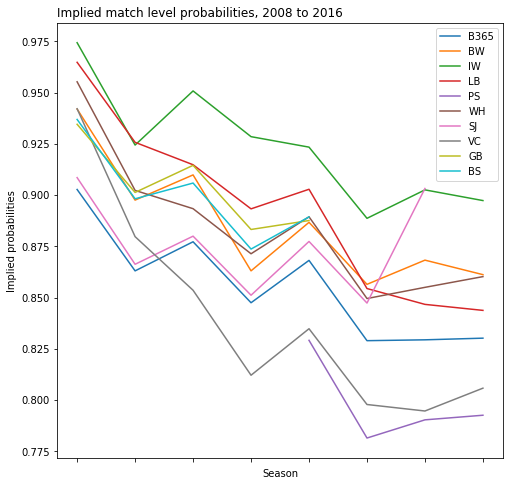

In [43]:
# Implied probabilities per bookmaker, by season

# First let's extract from SQL the average of odds per bookmaker split by result, this time grouped by season

conn = sqlite3.connect('database.sqlite')
df_gam_SQLSQL_s = pd.read_sql("SELECT m.season, AVG(m.B365H) B365H, AVG(m.B365D) B365D, AVG(m.B365A) B365A, AVG(m.BWH) BWH, AVG(m.BWD) BWD, AVG(m.BWA) BWA, AVG(m.IWH) IWH, AVG(m.IWD) IWD, AVG(m.IWA) IWA, AVG(m.LBH) LBH, AVG(m.LBD) LBD, AVG(m.LBA) LBA, AVG(m.PSH) PSH, AVG(m.PSD) PSD, AVG(m.PSA) PSA, AVG(m.WHH) WHH, AVG(m.WHD) WHD, AVG(m.WHA) WHA, AVG(m.SJH) SJH, AVG(m.SJD) SJD, AVG(m.SJA) SJA, AVG(m.VCH) VCH, AVG(m.VCD) VCD, AVG(m.VCA) VCA, AVG(m.GBH) GBH, AVG(m.GBD) GBD, AVG(m.GBA) GBA, AVG(m.BSH) BSH, AVG(m.BSD) BSD, AVG(m.BSA) BSA FROM Match m LEFT JOIN League l ON m.league_id = l.id GROUP BY 1", conn)
conn.close()
df_gam_SQLSQL_s

# Then let's convert them to implied probabilities by dividing them into 1

df_1 = pd.DataFrame()
df_1['season'] = df_gam_SQLSQL_s['season']
df_2 = df_gam_SQLSQL_s.iloc[:,1:].applymap(lambda x: 1/x)
df_gam_SQLSQL_s_1fun = pd.concat([df_1, df_2], axis=1)
df_gam_SQLSQL_s_1fun

# Finally let's cobmine the 3 possible results to match level

df_gam_SQLSQL_s_1fun_con = pd.DataFrame()
df_gam_SQLSQL_s_1fun_con['Season'] = df_gam_SQLSQL_s_1fun['season']
df_gam_SQLSQL_s_1fun_con['B365'] = df_gam_SQLSQL_s_1fun['B365H'] + df_gam_SQLSQL_s_1fun['B365D'] + df_gam_SQLSQL_s_1fun['B365A']
df_gam_SQLSQL_s_1fun_con['BW'] = df_gam_SQLSQL_s_1fun['BWH'] + df_gam_SQLSQL_s_1fun['BWD'] + df_gam_SQLSQL_s_1fun['BWA']
df_gam_SQLSQL_s_1fun_con['IW'] = df_gam_SQLSQL_s_1fun['IWH'] + df_gam_SQLSQL_s_1fun['IWD'] + df_gam_SQLSQL_s_1fun['IWA']
df_gam_SQLSQL_s_1fun_con['LB'] = df_gam_SQLSQL_s_1fun['LBH'] + df_gam_SQLSQL_s_1fun['LBD'] + df_gam_SQLSQL_s_1fun['LBA']
df_gam_SQLSQL_s_1fun_con['PS'] = df_gam_SQLSQL_s_1fun['PSH'] + df_gam_SQLSQL_s_1fun['PSD'] + df_gam_SQLSQL_s_1fun['PSA']
df_gam_SQLSQL_s_1fun_con['WH'] = df_gam_SQLSQL_s_1fun['WHH'] + df_gam_SQLSQL_s_1fun['WHD'] + df_gam_SQLSQL_s_1fun['WHA']
df_gam_SQLSQL_s_1fun_con['SJ'] = df_gam_SQLSQL_s_1fun['SJH'] + df_gam_SQLSQL_s_1fun['SJD'] + df_gam_SQLSQL_s_1fun['SJA']
df_gam_SQLSQL_s_1fun_con['VC'] = df_gam_SQLSQL_s_1fun['VCH'] + df_gam_SQLSQL_s_1fun['VCD'] + df_gam_SQLSQL_s_1fun['VCA']
df_gam_SQLSQL_s_1fun_con['GB'] = df_gam_SQLSQL_s_1fun['GBH'] + df_gam_SQLSQL_s_1fun['GBD'] + df_gam_SQLSQL_s_1fun['GBA']
df_gam_SQLSQL_s_1fun_con['BS'] = df_gam_SQLSQL_s_1fun['BSH'] + df_gam_SQLSQL_s_1fun['BSD'] + df_gam_SQLSQL_s_1fun['BSA']
df_gam_SQLSQL_s_1fun_con

# Plot match level implied probabilities per bookmaker over time

df_gam_SQLSQL_s_1fun_con.plot(x="Season", y=["B365", "BW", "IW", "LB", "PS", "WH", "SJ", "VC", "GB", "BS"], kind="line", figsize=(8, 8))

# Add titles
plt.title("Implied match level probabilities, 2008 to 2016", loc='left', fontsize=12, fontweight=0, color='black')
plt.ylabel("Implied probabilities");

Not only do we see that implied probabilities are < 1 every season, we also see a clear downward trend, suggesting that bookmakers are potentially becoming ever more generous.

In [45]:
# Implied match level probabilities per bookmaker, by league

# First let's extract from SQL the average of odds per bookmaker split by result, this time grouped by league name

conn = sqlite3.connect('database.sqlite')
df_gam_SQLSQL_l = pd.read_sql("SELECT l.name, AVG(m.B365H) B365H, AVG(m.B365D) B365D, AVG(m.B365A) B365A, AVG(m.BWH) BWH, AVG(m.BWD) BWD, AVG(m.BWA) BWA, AVG(m.IWH) IWH, AVG(m.IWD) IWD, AVG(m.IWA) IWA, AVG(m.LBH) LBH, AVG(m.LBD) LBD, AVG(m.LBA) LBA, AVG(m.PSH) PSH, AVG(m.PSD) PSD, AVG(m.PSA) PSA, AVG(m.WHH) WHH, AVG(m.WHD) WHD, AVG(m.WHA) WHA, AVG(m.SJH) SJH, AVG(m.SJD) SJD, AVG(m.SJA) SJA, AVG(m.VCH) VCH, AVG(m.VCD) VCD, AVG(m.VCA) VCA, AVG(m.GBH) GBH, AVG(m.GBD) GBD, AVG(m.GBA) GBA, AVG(m.BSH) BSH, AVG(m.BSD) BSD, AVG(m.BSA) BSA FROM Match m LEFT JOIN League l ON m.league_id = l.id GROUP BY 1", conn)
conn.close()
df_gam_SQLSQL_l

# Then let's convert them to implied probabilities by dividing them into 1

df_1 = pd.DataFrame()
df_1['name'] = df_gam_SQLSQL_l['name']
df_2 = df_gam_SQLSQL_l.iloc[:,1:].applymap(lambda x: 1/x)
df_gam_SQLSQL_l_1fun = pd.concat([df_1, df_2], axis=1)
df_gam_SQLSQL_l_1fun

# Next let's cobmine the 3 possible results to match level

df_gam_SQLSQL_l_1fun_con = pd.DataFrame()
df_gam_SQLSQL_l_1fun_con['League'] = df_gam_SQLSQL_l_1fun['name']
df_gam_SQLSQL_l_1fun_con['B365'] = df_gam_SQLSQL_l_1fun['B365H'] + df_gam_SQLSQL_l_1fun['B365D'] + df_gam_SQLSQL_l_1fun['B365A']
df_gam_SQLSQL_l_1fun_con['BW'] = df_gam_SQLSQL_l_1fun['BWH'] + df_gam_SQLSQL_l_1fun['BWD'] + df_gam_SQLSQL_l_1fun['BWA']
df_gam_SQLSQL_l_1fun_con['IW'] = df_gam_SQLSQL_l_1fun['IWH'] + df_gam_SQLSQL_l_1fun['IWD'] + df_gam_SQLSQL_l_1fun['IWA']
df_gam_SQLSQL_l_1fun_con['LB'] = df_gam_SQLSQL_l_1fun['LBH'] + df_gam_SQLSQL_l_1fun['LBD'] + df_gam_SQLSQL_l_1fun['LBA']
df_gam_SQLSQL_l_1fun_con['PS'] = df_gam_SQLSQL_l_1fun['PSH'] + df_gam_SQLSQL_l_1fun['PSD'] + df_gam_SQLSQL_l_1fun['PSA']
df_gam_SQLSQL_l_1fun_con['WH'] = df_gam_SQLSQL_l_1fun['WHH'] + df_gam_SQLSQL_l_1fun['WHD'] + df_gam_SQLSQL_l_1fun['WHA']
df_gam_SQLSQL_l_1fun_con['SJ'] = df_gam_SQLSQL_l_1fun['SJH'] + df_gam_SQLSQL_l_1fun['SJD'] + df_gam_SQLSQL_l_1fun['SJA']
df_gam_SQLSQL_l_1fun_con['VC'] = df_gam_SQLSQL_l_1fun['VCH'] + df_gam_SQLSQL_l_1fun['VCD'] + df_gam_SQLSQL_l_1fun['VCA']
df_gam_SQLSQL_l_1fun_con['GB'] = df_gam_SQLSQL_l_1fun['GBH'] + df_gam_SQLSQL_l_1fun['GBD'] + df_gam_SQLSQL_l_1fun['GBA']
df_gam_SQLSQL_l_1fun_con['BS'] = df_gam_SQLSQL_l_1fun['BSH'] + df_gam_SQLSQL_l_1fun['BSD'] + df_gam_SQLSQL_l_1fun['BSA']

# Finally let's highlight max and min values in yellow and orange, respectively

# Functions from https://pandas.pydata.org/pandas-docs/stable/style.html

df_improb_league = df_gam_SQLSQL_l_1fun_con.set_index('League')

def highlight_max(s):
    '''
    highlight max values in yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight min values in orange
    '''
    is_min = s == s.min()
    return ['background-color: orange' if v else '' for v in is_min]

df_improb_league.style.\
    apply(highlight_min).\
    apply(highlight_max)

,B365,BW,IW,LB,PS,WH,SJ,VC,GB,BS
League,,,,,,,,,,
Belgium Jupiler League,0.912997,0.939765,0.980043,0.960469,0.874357,0.953896,0.919806,0.914077,0.952276,0.956258
England Premier League,0.826739,0.869433,0.90452,0.864112,0.815893,0.860728,0.838294,0.823266,0.868413,0.854613
France Ligue 1,0.933655,0.949007,0.982685,0.973001,0.869554,0.952264,0.94897,0.915583,0.975878,0.979154
Germany 1. Bundesliga,0.869181,0.895968,0.930097,0.891421,0.777646,0.890085,0.896603,0.848556,0.924519,0.924782
Italy Serie A,0.896275,0.911765,0.945223,0.925249,0.827811,0.916455,0.913101,0.875651,0.930793,0.93437
Netherlands Eredivisie,0.831828,0.873079,0.913261,0.887631,0.820559,0.869772,0.833871,0.82032,0.864835,0.846839
Poland Ekstraklasa,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Portugal Liga ZON Sagres,0.812122,0.840068,0.893653,0.857498,0.737517,0.859021,0.8513,0.79345,0.880328,0.894053
Scotland Premier League,0.858297,0.913118,0.940321,0.872856,0.835868,0.88347,0.889268,0.843582,0.906874,0.877106


Again we can see that the match level implied probabilities are <1. We also see a clear pattern in terms of where bookmakers implied probabilities are highest and lowest, France and Spain, respectively. 

Before looking in more detail at these patterns, that let's look more closely at the match level implied probabilities. As stated at the beginning I was expecting them to be > 1. Instead, they're < 1 and decreasing over time. Let's see if this means that bookmakers are being generous.

## Exploring data - rates of return

Let's look at the bookmakers at the extremes of the match level implied probabilities, PS with 0.80 and IW with 0.92. To bet risk free we'd need to place the same bet on each of the 3 match results, so if the mean of the winning odds is >3 then we could bet equally on all results and return a profit. 

In [16]:
# Calculate the odds paid out across all winners by PS

conn = sqlite3.connect('database.sqlite')
df_winning_odds = pd.read_sql("SELECT CASE WHEN home_team_goal > away_team_goal THEN PSH WHEN home_team_goal = away_team_goal THEN PSD ELSE PSA END AS winning_odds FROM Match", conn)
conn.close()
df_winning_odds.describe()

,winning_odds
count,11168.000000
mean,2.907805
std,1.663434
min,1.040000
25%,1.790000
50%,2.600000
75%,3.550000
max,36.030000


In [9]:
# Calculate the odds paid out across all winners by IW

conn = sqlite3.connect('database.sqlite')
df_risk = pd.read_sql("SELECT CASE WHEN m.home_team_goal > m.away_team_goal THEN m.IWH WHEN m.home_team_goal = m.away_team_goal THEN m.IWD ELSE m.IWA END AS winning_odds FROM Match m", conn)
conn.close()
df_risk.describe()

,winning_odds
count,22520.000000
mean,2.641211
std,1.236064
min,1.030000
25%,1.750000
50%,2.400000
75%,3.300000
max,20.000000


Ok so that's interesting. We can see that the mean of winning odds is slightly less than 3. The bookmaker that came out of the original analysis looking like the potentially more generous returns a mean of 2.91 and the bookmaker that appeared less generous returns a mean of 2.64. 

This shows that the strategy of betting on all events would not work. Which seems reasonable. Further the mean returns are directionally the same as our previous analysis. PS looks the more generous in both cases, IW least. This is only two data points but helps to create confidence in the earlier analysis. 

Let's check another simple strategy, that of always betting on the favourite. 

To calculate how often the favourite wins we need to compare results to the odds. For example, if the result is a home win and the lowest odds were for a home win then we can say that the favourite won. The same would be true for draws and losses. The opposite would be true in the event the favourite doesn't win. Counting the odds for a winning favourite and 0 for a losing favourite, we can then look at the average across all matches to guage our expected return. This time we're only betting on one event, the favourite. So if the startegy is to be successful the mean should be > 1. 

In [17]:
# Calculate payout rate for match favourite with PS

conn = sqlite3.connect('database.sqlite')
df_favourite_PS = pd.read_sql("SELECT PSH, PSD, PSA, CASE WHEN home_team_goal > away_team_goal AND (PSH <= PSD AND PSH <= PSA) THEN PSH WHEN home_team_goal > away_team_goal AND NOT (PSH <= PSD AND PSH <= PSA) THEN 0 WHEN home_team_goal = away_team_goal AND (PSD < PSH AND PSD < PSA) THEN PSD WHEN home_team_goal = away_team_goal AND NOT (PSD < PSH AND PSD < PSA) THEN 0 WHEN home_team_goal < away_team_goal AND (PSA < PSH AND PSA < PSD) THEN PSA WHEN home_team_goal < away_team_goal AND NOT (PSA < PSH AND PSA < PSD) THEN 0 ELSE null END AS payout FROM Match", conn)                              
conn.close()
df_favourite_PS.describe()

,PSH,PSD,PSA,payout
count,11168.000000,11168.000000,11168.000000,11168.000000
mean,2.816447,4.132324,4.972744,0.972592
std,2.187924,1.516680,4.475458,0.976522
min,1.040000,2.200000,1.090000,0.000000
25%,1.720000,3.410000,2.560000,0.000000
50%,2.200000,3.640000,3.610000,1.200000
75%,2.980000,4.230000,5.410000,1.860000
max,36.000000,29.000000,47.500000,2.880000


In [18]:
# Calculate payout rate for match favourite with IW

conn = sqlite3.connect('database.sqlite')
df_favourite_IW = pd.read_sql("SELECT IWH, IWD, IWA, CASE WHEN home_team_goal > away_team_goal AND (IWH <= IWD AND IWH <= IWA) THEN IWH WHEN home_team_goal > away_team_goal AND NOT (IWH <= IWD AND IWH <= IWA) THEN 0 WHEN home_team_goal = away_team_goal AND (IWD < IWH AND IWD < IWA) THEN IWD WHEN home_team_goal = away_team_goal AND NOT (IWD < IWH AND IWD < IWA) THEN 0 WHEN home_team_goal < away_team_goal AND (IWA < IWH AND IWA < IWD) THEN IWA WHEN home_team_goal < away_team_goal AND NOT (IWA < IWH AND IWA < IWD) THEN 0 ELSE null END AS payout FROM Match", conn)                              
conn.close()
df_favourite_IW.describe()

,IWH,IWD,IWA,payout
count,22520.000000,22520.000000,22520.000000,22520.000000
mean,2.467613,3.608932,4.150575,0.952314
std,1.445642,0.803582,2.858912,0.941423
min,1.030000,1.500000,1.100000,0.000000
25%,1.650000,3.200000,2.500000,0.000000
50%,2.100000,3.300000,3.300000,1.200000
75%,2.600000,3.700000,4.600000,1.800000
max,20.000000,11.000000,25.000000,2.700000


Then mean payout in both cases is < 1 so again we can conclude that the simple strategy would be unsuccessful. This appears to be further evidence that bookmakers do build a margin into their odds just not on the match level that we saw at the beginning. Again we also see that our more generous bookmaker PS pays out a higher rate (0.972592) than IW (0.952314).

So far we've seen that the implied probabilities on a match level are very low, suggesting generous odds. However, now we've seen that the payout on the favourite is very low. This might suggest that match level odds are generous as bookmakers increase the odds on less likely events to make them more enticing. Again though we wouldn't expect bookmakers to be paying out regularly enough that they would lose money easily. To be sure let's check what the payout would be if we would bet on the 2nd and 3rd favourites.

In [22]:
# Calculate payout rate for 1st, 2nd and 3rd favourites with PS

conn = sqlite3.connect('database.sqlite')
df_favourites_PS = pd.read_sql("SELECT PSH, PSD, PSA, CASE WHEN home_team_goal > away_team_goal AND (PSH <= PSD AND PSH <= PSA) THEN PSH WHEN home_team_goal > away_team_goal AND NOT (PSH <= PSD AND PSH <= PSA) THEN 0 WHEN home_team_goal = away_team_goal AND (PSD <= PSH AND PSD <= PSA) THEN PSD WHEN home_team_goal = away_team_goal AND NOT (PSD <= PSH AND PSD <= PSA) THEN 0 WHEN home_team_goal < away_team_goal AND (PSA <= PSH AND PSA <= PSD) THEN PSA WHEN home_team_goal < away_team_goal AND NOT (PSA <= PSH AND PSA <= PSD) THEN 0 ELSE null END AS pay_fav1, CASE WHEN home_team_goal > away_team_goal AND ((PSH <= PSD AND PSH >= PSA) OR (PSH >= PSD AND PSH <= PSA)) THEN PSH WHEN home_team_goal > away_team_goal AND NOT ((PSH <= PSD AND PSH >= PSA) OR (PSH >= PSD AND PSH <= PSA)) THEN 0 WHEN home_team_goal = away_team_goal AND ((PSD <= PSH AND PSD >= PSA) OR (PSH >= PSD AND PSH <= PSA)) THEN PSD WHEN home_team_goal = away_team_goal AND NOT ((PSD <= PSH AND PSD >= PSA) OR (PSH >= PSD AND PSH <= PSA)) THEN 0 WHEN home_team_goal < away_team_goal AND ((PSA <= PSH AND PSA >= PSD) OR (PSH >= PSD AND PSH <= PSA)) THEN PSA WHEN home_team_goal < away_team_goal AND NOT ((PSA <= PSH AND PSA >= PSD) OR (PSH >= PSD AND PSH <= PSA)) THEN 0 ELSE null END AS pay_fav2, CASE WHEN home_team_goal > away_team_goal AND (PSH >= PSD AND PSH >= PSA) THEN PSH WHEN home_team_goal > away_team_goal AND NOT (PSH >= PSD AND PSH >= PSA) THEN 0 WHEN home_team_goal = away_team_goal AND (PSD >= PSH AND PSD >= PSA) THEN PSD WHEN home_team_goal = away_team_goal AND NOT (PSD >= PSH AND PSD >= PSA) THEN 0 WHEN home_team_goal < away_team_goal AND (PSA >= PSH AND PSA >= PSD) THEN PSA WHEN home_team_goal < away_team_goal AND NOT (PSA >= PSH AND PSA >= PSD) THEN 0 ELSE null END AS pay_fav3 FROM Match", conn)   
conn.close()
df_favourites_PS.mean()

PSH         2.816447
PSD         4.132324
PSA         4.972744
pay_fav1    0.975784
pay_fav2    0.282050
pay_fav3    0.974359
dtype: float64

In [21]:
# Calculate payout rate for 1st, 2nd and 3rd favourites with IW

conn = sqlite3.connect('database.sqlite')
df_favourites_IW = pd.read_sql("SELECT IWH, IWD, IWA, CASE WHEN home_team_goal > away_team_goal AND (IWH <= IWD AND IWH <= IWA) THEN IWH WHEN home_team_goal > away_team_goal AND NOT (IWH <= IWD AND IWH <= IWA) THEN 0 WHEN home_team_goal = away_team_goal AND (IWD <= IWH AND IWD <= IWA) THEN IWD WHEN home_team_goal = away_team_goal AND NOT (IWD <= IWH AND IWD <= IWA) THEN 0 WHEN home_team_goal < away_team_goal AND (IWA <= IWH AND IWA <= IWD) THEN IWA WHEN home_team_goal < away_team_goal AND NOT (IWA <= IWH AND IWA <= IWD) THEN 0 ELSE null END AS pay_fav1, CASE WHEN home_team_goal > away_team_goal AND ((IWH <= IWD AND IWH >= IWA) OR (IWH >= IWD AND IWH <= IWA)) THEN IWH WHEN home_team_goal > away_team_goal AND NOT ((IWH <= IWD AND IWH >= IWA) OR (IWH >= IWD AND IWH <= IWA)) THEN 0 WHEN home_team_goal = away_team_goal AND ((IWD <= IWH AND IWD >= IWA) OR (IWH >= IWD AND IWH <= IWA)) THEN IWD WHEN home_team_goal = away_team_goal AND NOT ((IWD <= IWH AND IWD >= IWA) OR (IWH >= IWD AND IWH <= IWA)) THEN 0 WHEN home_team_goal < away_team_goal AND ((IWA <= IWH AND IWA >= IWD) OR (IWH >= IWD AND IWH <= IWA)) THEN IWA WHEN home_team_goal < away_team_goal AND NOT ((IWA <= IWH AND IWA >= IWD) OR (IWH >= IWD AND IWH <= IWA)) THEN 0 ELSE null END AS pay_fav2, CASE WHEN home_team_goal > away_team_goal AND (IWH >= IWD AND IWH >= IWA) THEN IWH WHEN home_team_goal > away_team_goal AND NOT (IWH >= IWD AND IWH >= IWA) THEN 0 WHEN home_team_goal = away_team_goal AND (IWD >= IWH AND IWD >= IWA) THEN IWD WHEN home_team_goal = away_team_goal AND NOT (IWD >= IWH AND IWD >= IWA) THEN 0 WHEN home_team_goal < away_team_goal AND (IWA >= IWH AND IWA >= IWD) THEN IWA WHEN home_team_goal < away_team_goal AND NOT (IWA >= IWH AND IWA >= IWD) THEN 0 ELSE null END AS pay_fav3 FROM Match", conn)   
conn.close()
df_favourites_IW.mean()

IWH         2.467613
IWD         3.608932
IWA         4.150575
pay_fav1    0.984499
pay_fav2    0.266356
pay_fav3    0.890551
dtype: float64

So as expected, blindly betting on the 2nd or 3rd favourite wouldn't be a profitable venture. Again, we see that PS rates are more generous than IW (2nd 0.28 vs 0.27 and 3rd 0.97 vs 0.89). Also there's notable pattern of low rates of returns on the 2nd favourite and 3rd favourite rates that are similar to but lower than the 1st.

Let's conclude by continuing this theme of similarities between bookmakers and revisiting the trend we saw earlier that bookmakers offer different rates across different leagues and those differences are similar amongst bookmakers.

Previously we saw this on in terms of match level implied probabilities, which as we've seen are a good guide to bookmaker margin but probably aren't as clear as looking at the rate paid out on the favourite.  

/Users/matt_147/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


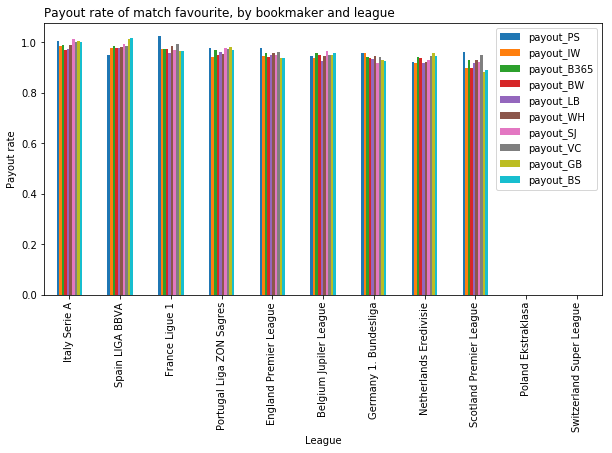

In [41]:
# Calculate payout rate for match favourite for all bookmakers, by league

conn = sqlite3.connect('database.sqlite')
df_favourite_PS_IW_leagues = pd.read_sql("SELECT l.name League, AVG(CASE WHEN home_team_goal > away_team_goal AND (PSH <= PSD AND PSH <= PSA) THEN PSH WHEN home_team_goal > away_team_goal AND NOT (PSH <= PSD AND PSH <= PSA) THEN 0 WHEN home_team_goal = away_team_goal AND (PSD < PSH AND PSD < PSA) THEN PSD WHEN home_team_goal = away_team_goal AND NOT (PSD < PSH AND PSD < PSA) THEN 0 WHEN home_team_goal < away_team_goal AND (PSA < PSH AND PSA < PSD) THEN PSA WHEN home_team_goal < away_team_goal AND NOT (PSA < PSH AND PSA < PSD) THEN 0 ELSE null END) AS payout_PS, AVG(CASE WHEN home_team_goal > away_team_goal AND (IWH <= IWD AND IWH <= IWA) THEN IWH WHEN home_team_goal > away_team_goal AND NOT (IWH <= IWD AND IWH <= IWA) THEN 0 WHEN home_team_goal = away_team_goal AND (IWD < IWH AND IWD < IWA) THEN IWD WHEN home_team_goal = away_team_goal AND NOT (IWD < IWH AND IWD < IWA) THEN 0 WHEN home_team_goal < away_team_goal AND (IWA < IWH AND IWA < IWD) THEN IWA WHEN home_team_goal < away_team_goal AND NOT (IWA < IWH AND IWA < IWD) THEN 0 ELSE null END) AS payout_IW, AVG(CASE WHEN home_team_goal > away_team_goal AND (B365H <= B365D AND B365H <= B365A) THEN B365H WHEN home_team_goal > away_team_goal AND NOT (B365H <= B365D AND B365H <= B365A) THEN 0 WHEN home_team_goal = away_team_goal AND (B365D < B365H AND B365D < B365A) THEN B365D WHEN home_team_goal = away_team_goal AND NOT (B365D < B365H AND B365D < B365A) THEN 0 WHEN home_team_goal < away_team_goal AND (B365A < B365H AND B365A < B365D) THEN B365A WHEN home_team_goal < away_team_goal AND NOT (B365A < B365H AND B365A < B365D) THEN 0 ELSE null END) AS payout_B365, AVG(CASE WHEN home_team_goal > away_team_goal AND (BWH <= BWD AND BWH <= BWA) THEN BWH WHEN home_team_goal > away_team_goal AND NOT (BWH <= BWD AND BWH <= BWA) THEN 0 WHEN home_team_goal = away_team_goal AND (BWD < BWH AND BWD < BWA) THEN BWD WHEN home_team_goal = away_team_goal AND NOT (BWD < BWH AND BWD < BWA) THEN 0 WHEN home_team_goal < away_team_goal AND (BWA < BWH AND BWA < BWD) THEN BWA WHEN home_team_goal < away_team_goal AND NOT (BWA < BWH AND BWA < BWD) THEN 0 ELSE null END) AS payout_BW, AVG(CASE WHEN home_team_goal > away_team_goal AND (LBH <= LBD AND LBH <= LBA) THEN LBH WHEN home_team_goal > away_team_goal AND NOT (LBH <= LBD AND LBH <= LBA) THEN 0 WHEN home_team_goal = away_team_goal AND (LBD < LBH AND LBD < LBA) THEN LBD WHEN home_team_goal = away_team_goal AND NOT (LBD < LBH AND LBD < LBA) THEN 0 WHEN home_team_goal < away_team_goal AND (LBA < LBH AND LBA < LBD) THEN LBA WHEN home_team_goal < away_team_goal AND NOT (LBA < LBH AND LBA < LBD) THEN 0 ELSE null END) AS payout_LB, AVG(CASE WHEN home_team_goal > away_team_goal AND (WHH <= WHD AND WHH <= WHA) THEN WHH WHEN home_team_goal > away_team_goal AND NOT (WHH <= WHD AND WHH <= WHA) THEN 0 WHEN home_team_goal = away_team_goal AND (WHD < WHH AND WHD < WHA) THEN WHD WHEN home_team_goal = away_team_goal AND NOT (WHD < WHH AND WHD < WHA) THEN 0 WHEN home_team_goal < away_team_goal AND (WHA < WHH AND WHA < WHD) THEN WHA WHEN home_team_goal < away_team_goal AND NOT (WHA < WHH AND WHA < WHD) THEN 0 ELSE null END) AS payout_WH, AVG(CASE WHEN home_team_goal > away_team_goal AND (SJH <= SJD AND SJH <= SJA) THEN SJH WHEN home_team_goal > away_team_goal AND NOT (SJH <= SJD AND SJH <= SJA) THEN 0 WHEN home_team_goal = away_team_goal AND (SJD < SJH AND SJD < SJA) THEN SJD WHEN home_team_goal = away_team_goal AND NOT (SJD < SJH AND SJD < SJA) THEN 0 WHEN home_team_goal < away_team_goal AND (SJA < SJH AND SJA < SJD) THEN SJA WHEN home_team_goal < away_team_goal AND NOT (SJA < SJH AND SJA < SJD) THEN 0 ELSE null END) AS payout_SJ, AVG(CASE WHEN home_team_goal > away_team_goal AND (VCH <= VCD AND VCH <= VCA) THEN VCH WHEN home_team_goal > away_team_goal AND NOT (VCH <= VCD AND VCH <= VCA) THEN 0 WHEN home_team_goal = away_team_goal AND (VCD < VCH AND VCD < VCA) THEN VCD WHEN home_team_goal = away_team_goal AND NOT (VCD < VCH AND VCD < VCA) THEN 0 WHEN home_team_goal < away_team_goal AND (VCA < VCH AND VCA < VCD) THEN VCA WHEN home_team_goal < away_team_goal AND NOT (VCA < VCH AND VCA < VCD) THEN 0 ELSE null END) AS payout_VC, AVG(CASE WHEN home_team_goal > away_team_goal AND (GBH <= GBD AND GBH <= GBA) THEN GBH WHEN home_team_goal > away_team_goal AND NOT (GBH <= GBD AND GBH <= GBA) THEN 0 WHEN home_team_goal = away_team_goal AND (GBD < GBH AND GBD < GBA) THEN GBD WHEN home_team_goal = away_team_goal AND NOT (GBD < GBH AND GBD < GBA) THEN 0 WHEN home_team_goal < away_team_goal AND (GBA < GBH AND GBA < GBD) THEN GBA WHEN home_team_goal < away_team_goal AND NOT (GBA < GBH AND GBA < GBD) THEN 0 ELSE null END) AS payout_GB, AVG(CASE WHEN home_team_goal > away_team_goal AND (BSH <= BSD AND BSH <= BSA) THEN BSH WHEN home_team_goal > away_team_goal AND NOT (BSH <= BSD AND BSH <= BSA) THEN 0 WHEN home_team_goal = away_team_goal AND (BSD < BSH AND BSD < BSA) THEN BSD WHEN home_team_goal = away_team_goal AND NOT (BSD < BSH AND BSD < BSA) THEN 0 WHEN home_team_goal < away_team_goal AND (BSA < BSH AND BSA < BSD) THEN BSA WHEN home_team_goal < away_team_goal AND NOT (BSA < BSH AND BSA < BSD) THEN 0 ELSE null END) AS payout_BS FROM Match LEFT JOIN League l ON Match.league_id = l.id GROUP BY 1", conn)                              
conn.close()
df_favourite_PS_IW_leagues['rough_ave'] = (df_favourite_PS_IW_leagues['payout_PS'] + df_favourite_PS_IW_leagues['payout_IW'] + df_favourite_PS_IW_leagues['payout_B365'] + df_favourite_PS_IW_leagues['payout_BW'] + df_favourite_PS_IW_leagues['payout_LB'] + df_favourite_PS_IW_leagues['payout_WH'] + df_favourite_PS_IW_leagues['payout_SJ'] + df_favourite_PS_IW_leagues['payout_VC'] + df_favourite_PS_IW_leagues['payout_GB'] + df_favourite_PS_IW_leagues['payout_BS'])/10
df_favourite_PS_IW_leagues_sorted = df_favourite_PS_IW_leagues.sort_values('rough_ave', axis=0, ascending=False)
df_favourite_PS_IW_leagues_sorted

# Plot payout per league for PS and IW
df_favourite_PS_IW_leagues_sorted.plot(x="League", y=["payout_PS", "payout_IW", "payout_B365", "payout_BW", "payout_LB", "payout_WH", "payout_SJ", "payout_VC", "payout_GB", "payout_BS"], kind="bar", figsize=(10, 5))

# Add titles
plt.title("Payout rate of match favourite, by bookmaker and league", loc='left', fontsize=12, fontweight=0, color='black')
plt.ylabel("Payout rate");

In the above chart we see variation among bookmakers within each market but I would argue that there is also a clear market trend for paying out higher returns for some markets over others. For example, at one extreme we have Italy and Spain and France where we see cases of bookmakers paying out rates > 1. At the other extreme Scotland stands out clearly as the market with lowest rates of return for the favourite, with 4 bookmakers returning rates < 0.9.

So it maybe that punters in Scotland are getting ripped off to some degree. It may also be that there are factors inherent to Scottish football that naturally leads to this outcome. For example, if Scottish matches would be more unpredictable we might expect bookmakers to err on the side of caution. I don't intend to answer the question here but using the likelihood of a home or away win as a quick proxy for match predictability we again see Spain and Scotland at opposite ends of the spectrum.

In [51]:
# The actual likelihood of a home win, draw and loss, by league.

conn = sqlite3.connect('database.sqlite')
df_actual_results_leagues = pd.read_sql("SELECT l.name, AVG(CASE WHEN m.home_team_goal > m.away_team_goal THEN 1 ELSE 0 END) AS home_win, AVG(CASE WHEN m.home_team_goal = m.away_team_goal THEN 1 ELSE 0 END) AS home_draw, AVG(CASE WHEN m.home_team_goal < m.away_team_goal THEN 1 ELSE 0 END) AS home_loss FROM Match m LEFT JOIN League l ON m.league_id = l.id GROUP BY 1", conn)
conn.close()
df_actual_results_leagues.sort_values('home_win', axis=0, ascending=False)

,name,home_win,home_draw,home_loss
9,Spain LIGA BBVA,0.488487,0.231579,0.279934
5,Netherlands Eredivisie,0.478350,0.237337,0.284314
0,Belgium Jupiler League,0.468750,0.245949,0.285301
4,Italy Serie A,0.466357,0.263838,0.269804
1,England Premier League,0.457237,0.257566,0.285197
10,Switzerland Super League,0.457103,0.243319,0.299578
6,Poland Ekstraklasa,0.453125,0.273438,0.273438
3,Germany 1. Bundesliga,0.452206,0.243873,0.303922
2,France Ligue 1,0.447039,0.282566,0.270395
7,Portugal Liga ZON Sagres,0.442495,0.259747,0.297758


## Conclusions

The analysis has shown that Bookmakers don't sum match odds to 1 as in the coin toss example. I will guess at the reason being that with a coin toss each event (head or tails) occurs roughly 50% of the time. Football (and sport generally) is different, as home teams and generally stronger teams win more often. So it's not that bookmakers are being overly generous but rather that they set higher, more enticing odds for less likely events which in turn reduces the sum of implied probabilities < 1.

Instead of using the sum of implied probabilities we've seen that the rate of return gives a clearer indication of bookmaker margins. The rates are nearly always < 1, with margins of between 0 and 10%. We've also seen a lot of patterns and similarities among bookmakers. (1) For all bookmakers the implied probabilities on match level are < 1 and decreasing over time. (2) All bookmakers offer better rates of return for the favourite, than they do for the 2nd or 3rd favourite match result. (3) Bookmakers tend to offer higher rates of returns for certain leagues, like Italy and Spain.

Some limitations to be aware of. Firstly, we only have a single set of odds per bookmaker, per result. In reality odds fluctuate. Also, we don't know how much was staked. In reality the more money is staked, the lower the odds will become to limit bookmaker exposure. Lastly, we don't know at what moment in time our odds were generated. It maybe that they were generated at different times, which could introduce unseen bias into the analysis. For example, some maybe opening odds, others closing or averages. If there are systematic events, such as, heavy betting immediately after opening or just before closing then the exact moment at which our snapshot odds are generated could have a significant effect on the analysis.